In [1]:
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [ ]:
train_csv_paths = list(glob(os.path.join('.', 'train_*.csv')))
valid_csv_paths = list(glob(os.path.join('.', 'valid_*.csv')))
assert len(train_csv_paths) > 0

In [ ]:
df = pd.read_csv(train_csv_paths[0])

In [ ]:
new_columns = {col: col.replace('validation__', '') for col in df.columns if col.startswith('validation__')}
df = df.rename(columns=new_columns)

In [ ]:
unweighted_sample_cols = [
    str(col) for col in df.columns if 'unweigted_sample_loss' in col
]

In [ ]:
epochs = sorted(list(set(df.epoch_id)))
epochs

In [ ]:
unweighted_losses = []
for i in epochs:
    loss = df.loc[df.epoch_id == i].iloc[:, df.columns.isin(unweighted_sample_cols)].sum(axis=1).mean()
    unweighted_losses.append(loss)
plt.plot(unweighted_losses)

In [ ]:
cols = list(df.columns)
rotation_cols = list(col for col in cols if '_rotation_' in col and 'sample_loss' in col)
position_cols = list(col for col in cols if '_position_' in col and 'sample_loss' in col)
fig = plt.figure()
mean_loss = df[rotation_cols + position_cols + ['epoch_id']].groupby('epoch_id').mean()
ax = mean_loss.plot(ylabel='cross_entropy_loss')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
per_task_loss = df[rotation_cols + position_cols + ['task']].groupby('task').sum().sum(axis=1).sort_values()
per_task_loss / per_task_loss.min()

Learning Rate

In [ ]:
import math 
from playground.typing import TrainParam, DatasetParam

def get_lr_param():
    return {
        "warmup_end_at_iters": 7000,
        "flatten_end_at_iters": 240000,
        "lr_decay_end_at_iters": 960000,
        "learning_rate": 1e-5,
        "min_lr": 1e-7, 
    }


def get_optimizer_param():
    return {
        "clip_norm": 1.0,
        "inital_lr": get_lr_param()["learning_rate"],
        "optimizer_name": "AdamW",
        "weight_decay": 0.0
    }

def get_dataset_param():
    return  {
        "data_pct_usage": 1.0,
        "total_data_size_per_task": 40000,
        "validation_pct": 0.00,
        "source": "s3://vima",
        "tasks": [
            "follow_order",
            "manipulate_old_neighbor",
            "novel_adj",
            "novel_noun",
            "pick_in_order_then_restore",
            "rearrange_then_restore",
            "rearrange",
            "rotate",
            "same_profile",
            "scene_understanding",
            "simple_manipulation",
            "sweep_without_exceeding",
            "twist",
        ]
    }

def get_train_param():
    return {
        "model_size": "2M",
        "total_epoch": 50,
        "local_batch_size": 128,
        "distributed": False,
    }
def get_lr(it: int) -> float:
    lr_param = get_lr_param()
    warmup_iters = lr_param["warmup_end_at_iters"]
    flatten_iters = lr_param["flatten_end_at_iters"]
    learning_rate = lr_param["learning_rate"]
    lr_decay_iters = lr_param["lr_decay_end_at_iters"]
    min_lr = lr_param["min_lr"]
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if warmup_iters <= it < flatten_iters:
        return learning_rate
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - flatten_iters) / (lr_decay_iters - flatten_iters)
    assert 0 <= decay_ratio <= 1, f"{decay_ratio = }, {it = }"
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


def get_batch_per_epoch(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        is_train: bool = True
    ):
    if is_train:
        scaling = 1.0
    else:
        scaling = dataset_param["validation_pct"]
    epoch_size = ( 
        int(
            dataset_param["total_data_size_per_task"] 
            * scaling 
            * len(dataset_param["tasks"]
        ) 
        * dataset_param["data_pct_usage"]) 
    )
    batch_size = (
        train_param["local_batch_size"] 
            if train_param["distributed"] is False 
            else train_param["local_batch_size"] * 1
    )
    if epoch_size % batch_size != 0:
        return epoch_size // batch_size + 1
    return epoch_size // batch_size

def get_total_batch_count(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int,
        is_train: bool = True
    ) -> int:
    batch_count_per_epoch = get_batch_per_epoch(dataset_param, train_param, is_train)
    current_total_batch_count = batch_id + epoch_id * batch_count_per_epoch
    return current_total_batch_count

def measure_lr(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int
    ):
    current_total_batch_count = get_total_batch_count(
        dataset_param, 
        train_param, 
        batch_id, 
        epoch_id, 
        is_train=True
    )
    return get_lr(current_total_batch_count)

In [ ]:
def get_lrs():
    lrs = []
    for epoch_id in range(get_train_param()["total_epoch"]):
        for batch_id in range(
            get_batch_per_epoch(
                get_dataset_param(),
                get_train_param(),
            )
        ):
            lrs.append(
                measure_lr(
                    get_dataset_param(),
                    get_train_param(),
                    batch_id,
                    epoch_id
                )
            )
    return lrs

In [ ]:
lrs = get_lrs()
print(len(lrs))
_ = plt.plot(lrs)

Eval Result

In [24]:
df = pd.read_csv('eval_2024-06-17_clear-moon-835_39_0.csv')

In [25]:
def calc_success_rate(df):
    task_ids = {
        "visual_manipulation": "01",
        "scene_understanding": "02",
        "rotate": "03",
        "rearrange": "04",
        "rearrange_then_restore": "05",
        "novel_adj": "06",
        "novel_noun": "07",
        "novel_adj_and_noun": "08",
        "twist": "09",
        "follow_motion": "10",
        "follow_order": "11",
        "sweep_without_exceeding": "12",
        "sweep_without_touching": "13",
        "same_texture": "14",
        "same_shape": "15",
        "manipulate_old_neighbor": "16",
        "pick_in_order_then_restore": "17"
    }
    return {
        task_ids[group.iloc[0]['task']]: round(float(group[['sucess']].mean().iloc[0] * 100), 1)
            for _, group in df.groupby('task')
    }



In [26]:
eval_success_rates = calc_success_rate(df)

In [27]:
sorted(list(eval_success_rates.items()))

[('01', 100.0),
 ('02', 100.0),
 ('03', 100.0),
 ('04', 58.0),
 ('05', 37.0),
 ('06', 100.0),
 ('07', 100.0),
 ('09', 15.0),
 ('11', 67.0),
 ('12', 66.0),
 ('15', 94.0),
 ('16', 47.0),
 ('17', 76.0)]

In [208]:
data = {
    "01": [100.0, 100.0, 95.0],
    "02": [100.0, 100.0, 69.0],
    "03": [100.0, 100.0, 96.0],
    "04": [96.0, 58.0, 95.0],
    "05": [37.0, 37.0, 47.0],
    "06": [100.0, 100.0, 46.0],
    "07": [100.0, 100.0, 76.0],
    "09": [9.5, 15.0, 10.0],
    "11": [87.0, 67.0, 63.0],
    "12": [64.0, 66.0, 95.0],
    "15": [93.5, 94.0, 73.0],
    "16": [45.0, 47.0, 60.0],
    "17": [63.0, 76.0, 1.0],
    "avg": [76.5, 72.6, 63.5]

}

pd.DataFrame(data=data, index=["in paper", "40 epoch sort", "45 epoch shuffle"])

,01,02,03,04,05,06,07,09,11,12,15,16,17,avg
in paper,100.0,100.0,100.0,96.0,37.0,100.0,100.0,9.5,87.0,64.0,93.5,45.0,63.0,76.5
30 epoch sort,100.0,100.0,99.0,59.0,34.0,100.0,100.0,15.0,53.0,60.0,97.0,49.0,79.0,72.6
45 epoch shuffle,95.0,69.0,96.0,95.0,47.0,46.0,76.0,10.0,63.0,95.0,73.0,60.0,1.0,63.5


In [184]:
sum(eval_success_rates.values()) / len(eval_success_rates)

83.92307692307692

In [4]:
from glob import glob

In [18]:
all_results1 = glob(os.path.join('remote_eval', 'result', '*.csv'))
all_results2 = glob(os.path.join('hist_exp', 'remote_eval-2024_06_08', 'result', '*.csv'))
all_results1 = {
    epoch: path for epoch, path in 
    zip(
        map(
            lambda x: int(os.path.basename(x).split('_')[3]),
            all_results1
        ),
        all_results1
    ) 
}
all_results2 = {
    epoch: path for epoch, path in 
    zip(
        map(
            lambda x: int(os.path.basename(x).split('_')[3]),
            all_results2
        ),
        all_results2
    ) 
}
def parse_eval_csv(payload):
    epoch, path = payload
    return epoch, calc_success_rate(pd.read_csv(path))
success_rate_trace1 = list(map(
    parse_eval_csv,
    list(sorted(all_results1.items()))
))
success_rate_trace2 = list(map(
    parse_eval_csv,
    list(sorted(all_results2.items()))
))

In [19]:
def extract_single_success(task_id: str, trace: List[Tuple[int, Dict[str, float]]]):
    return ( 
        list(x[0] for x in trace),
        list(x[1][task_id] for x in trace)
    )
        
def extract_avg_success(trace: List[Tuple[int, Dict[str, float]]]):
    return ( 
        list(x[0] for x in trace),
        list(sum(x[1].values()) / len(x[1]) for x in trace)
    )

[52.0, 55.0, 57.0, 50.0, 59.0, 55.0, 57.0, 58.0, 61.0, 58.0, 61.0]

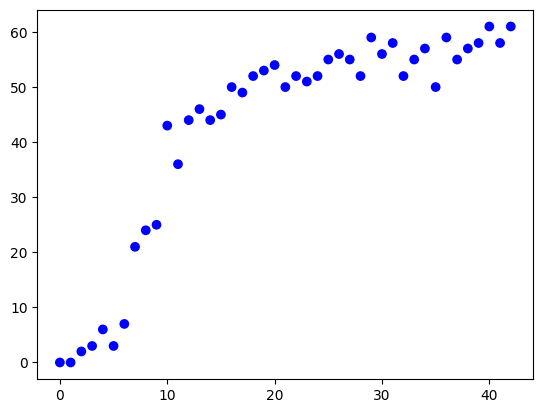

In [21]:
xs2, ys2 = extract_single_success("04", success_rate_trace1)
def decide(i):
    if i < 45:
        return 'b'
    elif 45 <= i <= 55:
        return 'g'
    return 'r'
colors = [decide(x) for x in xs2]
_ = plt.scatter(xs2, ys2, color=colors)
ys2[-11:]

[73.23076923076923,
 73.84615384615384,
 71.92307692307692,
 72.53846153846153,
 72.23076923076923]

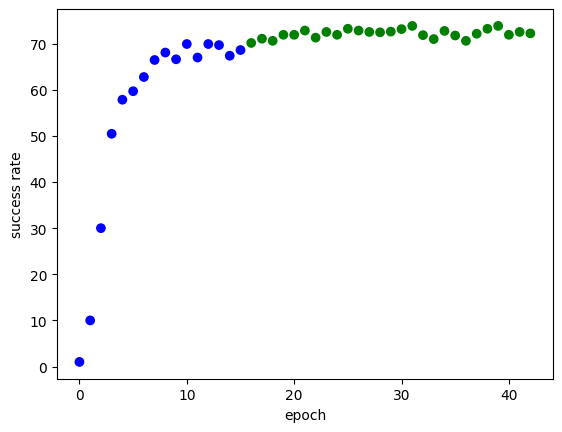

In [23]:
xs1, ys1 = extract_avg_success(success_rate_trace1)
xs2, ys2 = extract_avg_success(success_rate_trace2)
plt.xlabel('epoch')
plt.ylabel('success rate')
def decide1(i):
    if i > 15:
        return 'g'
    return 'b'
def decide2(i):
    return 'g'
colors1 = [decide1(x) for x in xs1]
colors2 = [decide2(x) for x in xs2]
t = 1000
_ = plt.scatter(xs1[:t], ys1[:t], color=colors1[:t])
#_ = plt.scatter(xs2[:t], ys2[:t], color=colors2[:t])
import heapq
heapq.nlargest(5, zip(ys1, range(len(ys1))))
ys1[-5:]

Evalution

In [ ]:
import pandas as pd
import glob


mode = 'train'
file_pattern = f'logs\\{mode}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
solution_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [ ]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe()

In [ ]:
for task_name, task_df in df[position_loss_cols + ['task']].groupby('task'):
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in position_loss_cols
    }
    print(task_name)
    print(task_df[position_loss_cols].rename(columns=rename).describe())
    print("=============")

In [ ]:
df['sum_loss'] = df[position_loss_cols].sum(axis=1)
df.groupby('task')['sum_loss'].describe().T.columns

In [78]:
import pandas as pd
import glob
import os
from typing import List, Literal, Callable

In [79]:

mode = 'train'
i = 8
    
file_pattern = f'logs\\{mode}_{i}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

In [80]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [81]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe().columns

Index(['pose0_position_0', 'pose0_position_1', 'pose1_position_0',
       'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
       'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
       'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'],
      dtype='object')

In [82]:
exps = set(
    [
        str(os.path.basename(file_path))
        .split('.')[0]
        .split('_')[2] 
            for file_path in glob.glob('logs/*.csv')
    ]
)

In [83]:
def get_trace_paths(
        exp_id: str, 
        mode: str
    ):
    return [
        exp
            for exp in sorted(
                glob.glob(f'logs/{mode}_*_{exp_id}.csv'),
                key = lambda x: int(x.split('_')[1])
            )
    ]

def trace_epoch(
        exp_id: str, 
        mode: str = 'train'
    ) -> List[pd.DataFrame]:
    return [
        pd.read_csv(exp)
            for exp in 
                get_trace_paths(exp_id, mode)
    ]

def trace_ddp(exp_ids: List[str], epoch: int, mode: str = 'train') -> pd.DataFrame:
    exp_paths = [
        os.path.join('logs', f'{mode}_{epoch}_{exp_id}.csv') for exp_id in exp_ids
    ]
    exp_paths = filter(lambda x: os.path.exists(x), exp_paths)
    dataframes = [
        pd.read_csv(exp_path) for exp_path in exp_paths
    ]
    df = pd.concat(dataframes, ignore_index=True)
    return df


In [ ]:
dfs = [
    trace_ddp(exps, i, 'train') for i in range(30)
]

In [84]:
Aggregator = Literal['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
Transform = Callable[[pd.DataFrame], pd.DataFrame]
def measure(
        df: pd.DataFrame, 
        transform: Transform, 
        attr: str, 
        aggr: Aggregator
    ) -> float:
    df = transform(df)
    describe = df.describe()
    if attr not in describe.columns:
        describe = describe.T
    return describe[attr][aggr]
    

In [85]:
attributes = [
    'pose0_position_0', 'pose0_position_1', 'pose1_position_0',
    'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
    'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
    'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'
]
tasks = [
    'follow_order', 'manipulate_old_neighbor', 'novel_adj', 'novel_noun',
    'pick_in_order_then_restore', 'rearrange', 'rearrange_then_restore',
    'rotate', 'same_profile', 'scene_understanding', 'simple_manipulation',
    'sweep_without_exceeding', 'twist'
]

In [86]:
def per_attr_transform(df: pd.DataFrame) -> pd.DataFrame:
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in loss_cols
    }
    return df[loss_cols].rename(columns=rename)

In [87]:
measure(solution_df, per_attr_transform, 'pose0_position_0', 'mean')

NameError: name 'solution_df' is not defined

In [88]:
for attr in attributes:
    print(attr, measure(df, per_attr_transform, attr, 'mean'))

pose0_position_0 2.492086167917114
pose0_position_1 2.581892437098347
pose1_position_0 2.5137275114073407
pose1_position_1 2.503110457770942
pose0_rotation_0 5.7197458065598557e-11
pose0_rotation_1 8.963588319451569e-11
pose0_rotation_2 6.533578847176194e-11
pose0_rotation_3 8.447795226428613e-11
pose1_rotation_0 7.102874697295647e-11
pose1_rotation_1 8.077180611875379e-11
pose1_rotation_2 0.12257853343453921
pose1_rotation_3 0.12253608272782314


In [89]:
def per_task_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    df['sum_loss'] = df[loss_cols].sum(axis=1)
    return df.groupby('task')['sum_loss']

In [90]:
for task in tasks:
    print(task, measure(
        df, 
        per_task_transform, 
        task, 
        'mean'))

follow_order 9.301210948833823
manipulate_old_neighbor 9.879311704775692
novel_adj 10.558656291997433
novel_noun 10.449915330833196
pick_in_order_then_restore 10.049875231191516
rearrange 12.152859887248278
rearrange_then_restore 12.975440729337931
rotate 10.369168365980354
same_profile 10.324291684383153
scene_understanding 10.444130369216204
simple_manipulation 10.44868229367137
sweep_without_exceeding 4.310659646831158
twist 13.102902996159095


In [ ]:

for task in attributes:
    print(task, measure(
        solution_df.loc[
            (solution_df['unweigted_sample_loss__pose0_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose1_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose0_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_3'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_3'] < 3.9) 
        ], 
        per_attr_transform, 
        task, 
        'mean'))

In [ ]:
measure(solution_df, per_task_transform, 'follow_order', 'mean')

In [ ]:
follow_order = [measure(df, per_task_transform, 'follow_order', 'mean') for df in dfs]
follow_order

### Trace Accu

In [95]:
import pandas as pd
from functools import partial

In [185]:
df = pd.read_csv('eval_200M_run.csv')

In [186]:

def per_trace_accu(row: pd.Series, col: str, threshold: float) -> float:
    correct_trace: List[int] = []
    for t_step in range(10):
        ground_truth = row.loc[f'action_trace__{t_step}__oracle_action__{col}']
        prediction = row.loc[f'action_trace__{t_step}__policy_action__{col}']
        if pd.isna(ground_truth) and pd.isna(prediction):
            break
        if pd.isna(ground_truth) or pd.isna(prediction):
            correct_trace.append(0)
            continue
        
        correct_trace.append(int(abs(ground_truth - prediction) <= threshold))
    if len(correct_trace) < 0:
        return 0
    return sum(correct_trace) / len(correct_trace)

        

In [187]:
attributes = [
    'pose0_position_0', 'pose0_position_1', 'pose1_position_0',
    'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
    'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
    'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'
]

In [188]:
accus = {
    attribute: df.apply(partial(per_trace_accu, col=attribute, threshold=0), axis=1).mean()
    for attribute in attributes 
}

In [189]:
position_accus = [accus[key] for key in accus if 'position' in key]
rotation_accus = [accus[key] for key in accus if 'rotation' in key]
sum(position_accus) / len(position_accus),  sum(rotation_accus) / len(rotation_accus),

(0.3929182692307693, 0.6720702838827838)

In [32]:
position_accus = [accus[key] for key in accus if 'position' in key]
rotation_accus = [accus[key] for key in accus if 'rotation' in key]
sum(position_accus) / len(position_accus),  sum(rotation_accus) / len(rotation_accus),

(0.383246336996337, 0.682220695970696)

In [192]:
all_mean = 0
for attribute in attributes:
    res = df.apply(partial(per_trace_accu, col=attribute, threshold=3), axis=1).mean()
    print(attribute, res)
    all_mean += res
all_mean /= len(attributes)
all_mean

pose0_position_0 0.9218250915750916
pose0_position_1 0.8348031135531137
pose1_position_0 0.918587912087912
pose1_position_1 0.8020137362637364
pose0_rotation_0 0.9943589743589742
pose0_rotation_1 0.9943589743589742
pose0_rotation_2 0.9943589743589742
pose0_rotation_3 0.9943589743589742
pose1_rotation_0 0.9943589743589742
pose1_rotation_1 0.9943589743589742
pose1_rotation_2 0.40315018315018314
pose1_rotation_3 0.2316886446886447


0.839851877289377

In [196]:
df['step_count'].sum() / df['total_time'].sum()

7.342410511942706

In [169]:
from functools import reduce
from collections import Counter

dfs = [pd.read_csv(f) for f in glob('logs\\*.csv')]
def measure_task_freq(df: pd.DataFrame):
    return df['task'].value_counts().to_dict()

def sum_counts(dict_list):
    return dict(reduce(lambda x, y: x + y, map(Counter, dict_list)))

counts = dict(reduce(lambda x, y: x + y, map(Counter, map(measure_task_freq, dfs))))
total_sum = sum(counts.values())
frequency = {key: round(value / total_sum, 3) for key, value in counts.items()}
frequency

{'pick_in_order_then_restore': 0.077,
 'twist': 0.077,
 'sweep_without_exceeding': 0.077,
 'rearrange_then_restore': 0.077,
 'rearrange': 0.077,
 'simple_manipulation': 0.077,
 'manipulate_old_neighbor': 0.077,
 'follow_order': 0.077,
 'rotate': 0.077,
 'same_profile': 0.077,
 'novel_noun': 0.077,
 'novel_adj': 0.077,
 'scene_understanding': 0.077}

In [126]:
with open('simple_shuffle.txt') as f:
    results = list(filter(lambda x: x.strip() in ('True', 'False',), f.readlines()))
    assert len(results) == 100
    print(sum(map(
        lambda x: 1 if x.strip() == 'True' else 0,
        results)
    ))

39


In [127]:
data = {
    "in paper": [100.0, 63.0],
    "no change": [100.0, 60.0],
    "reverse": [15.0, 0.0],
    "shuffle": [39.0, 2.0]
    
}
index = ['simple task', 'hard task']

pd.DataFrame(data=data, index=index).T

,simple task,hard task
in paper,100.0,63.0
no change,100.0,60.0
reverse,15.0,0.0
shuffle,39.0,2.0


Var analysis of evaluation

In [244]:
import pandas as pd
from glob import glob
from functools import reduce

In [245]:
def calc_success_rate(df):
    task_ids = {
        "visual_manipulation": "01",
        "scene_understanding": "02",
        "rotate": "03",
        "rearrange": "04",
        "rearrange_then_restore": "05",
        "novel_adj": "06",
        "novel_noun": "07",
        "novel_adj_and_noun": "08",
        "twist": "09",
        "follow_motion": "10",
        "follow_order": "11",
        "sweep_without_exceeding": "12",
        "sweep_without_touching": "13",
        "same_texture": "14",
        "same_shape": "15",
        "manipulate_old_neighbor": "16",
        "pick_in_order_then_restore": "17"
    }
    return {
        task_ids[group.iloc[0]['task']]: round(float(group[['sucess']].mean().iloc[0] * 100), 1)
            for _, group in df.groupby('task')
    }

In [246]:
dfs = [
    pd.read_csv(path) for path in glob("remote_eval\\result_per_seed\\*.csv")
]

Text(0.5, 0, 'task')

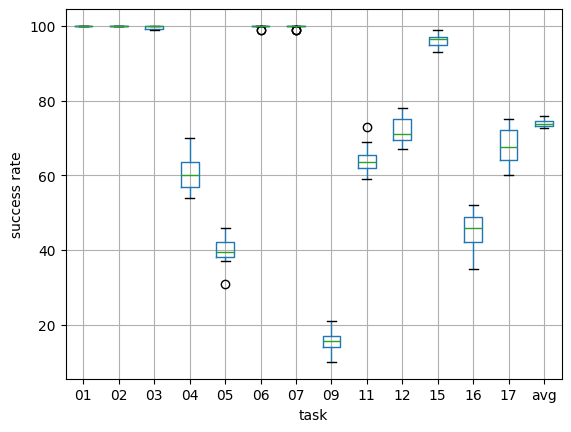

In [247]:
data = reduce(
    lambda x, y: {k: x[k] + y[k] for k in x.keys()},
    map(
        lambda x: {k: [v] for k, v in x.items()},
        map(
            lambda x: {**x, 'avg': round(sum(x.values()) / len(x), 2)},
            map(
                calc_success_rate, dfs
            )
        )
    ),
    {k: list() for k in list(calc_success_rate(dfs[0]).keys()) + ['avg']}
)
result = pd.DataFrame(data).reindex(sorted(data.keys()), axis=1)
ax = result.boxplot()
ax.set_ylabel('success rate')
ax.set_xlabel('task')

In [249]:
result.describe()

,01,02,03,04,05,06,07,09,11,12,15,16,17,avg
count,14.0,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,100.0,100.0,99.714286,60.642857,39.928571,99.857143,99.785714,15.714286,64.142857,72.214286,96.071429,45.357143,67.642857,73.927143
std,0.0,0.0,0.468807,4.970794,3.950935,0.363137,0.425815,3.148347,3.634390,3.598687,1.859044,5.001648,5.241948,0.972186
min,100.0,100.0,99.000000,54.000000,31.000000,99.000000,99.000000,10.000000,59.000000,67.000000,93.000000,35.000000,60.000000,72.620000
25%,100.0,100.0,99.250000,56.750000,38.000000,100.000000,100.000000,14.000000,62.000000,69.500000,95.000000,42.000000,64.000000,73.207500
50%,100.0,100.0,100.000000,60.000000,39.500000,100.000000,100.000000,15.500000,63.500000,71.000000,96.500000,46.000000,67.500000,73.690000
75%,100.0,100.0,100.000000,63.500000,42.000000,100.000000,100.000000,17.000000,65.500000,75.000000,97.000000,48.750000,72.250000,74.575000
max,100.0,100.0,100.000000,70.000000,46.000000,100.000000,100.000000,21.000000,73.000000,78.000000,99.000000,52.000000,75.000000,75.920000
